## Group 1 Project: Portfolio Prediction Model

##### This project focuses on developing a predictive model for financial portfolios, leveraging data mining techniques, machine learning algorithms, and data visualization to enhance portfolio management and forecasting capabilities.

**Objective:** To forecast stock prices and portfolio trends using advanced machine learning models.

**Overview:** This project combines data preprocessing, feature engineering, and model training to accurately predict portfolio values and optimize financial decision-making.

In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [4]:
# Import libraries
import math
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn-v0_8-pastel')

In [5]:
# Get stock data
end = dt.today()
start = end - timedelta(days=365*10)
df = yf.Ticker('AAPL').history(start=start, end=end)

In [6]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-12-08 00:00:00-05:00,25.409423,25.531906,24.857142,25.030844,230659600,0.0,0.0
2014-12-09 00:00:00-05:00,24.538692,25.453966,24.351628,25.413881,240832000,0.0,0.0
2014-12-10 00:00:00-05:00,25.478459,25.576444,24.839326,24.930630,178261200,0.0,0.0
2014-12-11 00:00:00-05:00,24.999666,25.342615,24.794786,24.857141,165606800,0.0,0.0
2014-12-12 00:00:00-05:00,24.598820,24.912820,24.402850,24.436255,224112400,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-29 00:00:00-05:00,234.809998,237.809998,233.970001,237.330002,28481400,0.0,0.0
2024-12-02 00:00:00-05:00,237.270004,240.789993,237.160004,239.589996,48137100,0.0,0.0
2024-12-03 00:00:00-05:00,239.809998,242.759995,238.899994,242.649994,38861000,0.0,0.0


### Data Preprocessing

In [8]:
df.shape

(2516, 7)

#### Handle Missing Data

In [10]:
if df.isnull().values.any():
    print("Missing values found. Handling them...")
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)
else:
    print("No missing values.")

No missing values.


#### Remove outliers or anomalies

In [12]:
df = df[df['Close'] > 0]  # Ensure no negative or zero values

#### Drop unwanted colums

In [14]:
del df['Dividends']
del df['Stock Splits']
del df['Volume']

#### Correlation Heatmap

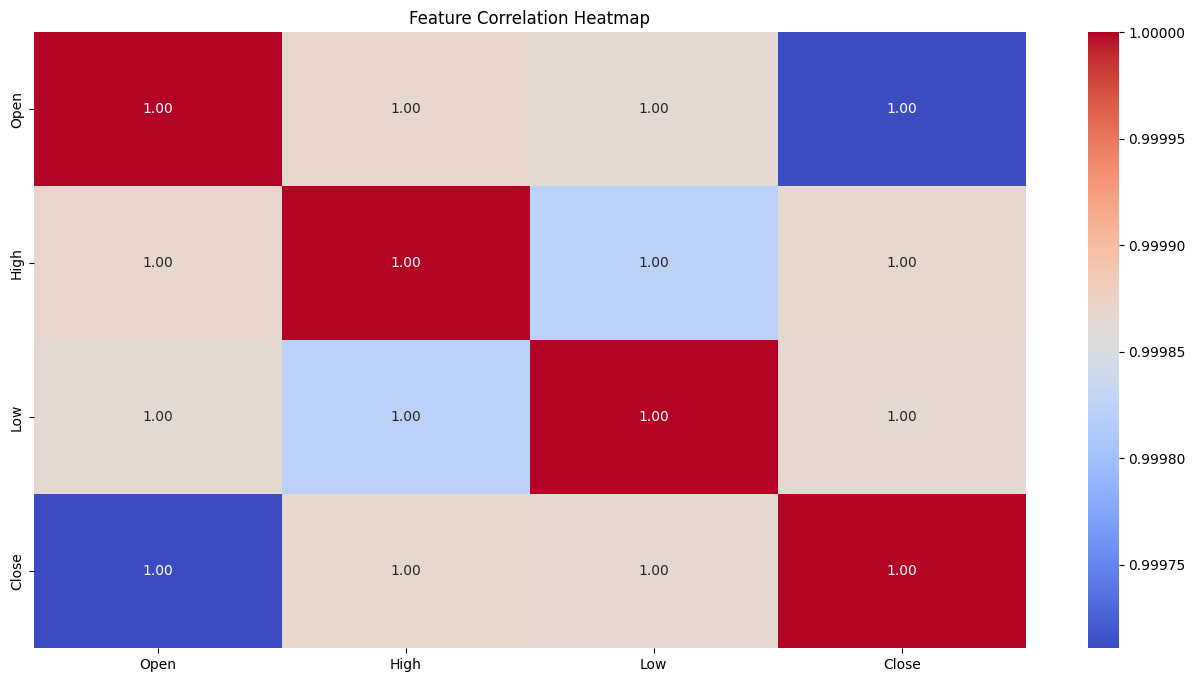

In [16]:
# Correlation Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

The above heatmap indicates a very strong positive correlation between the features - Open, High, Low, Close.

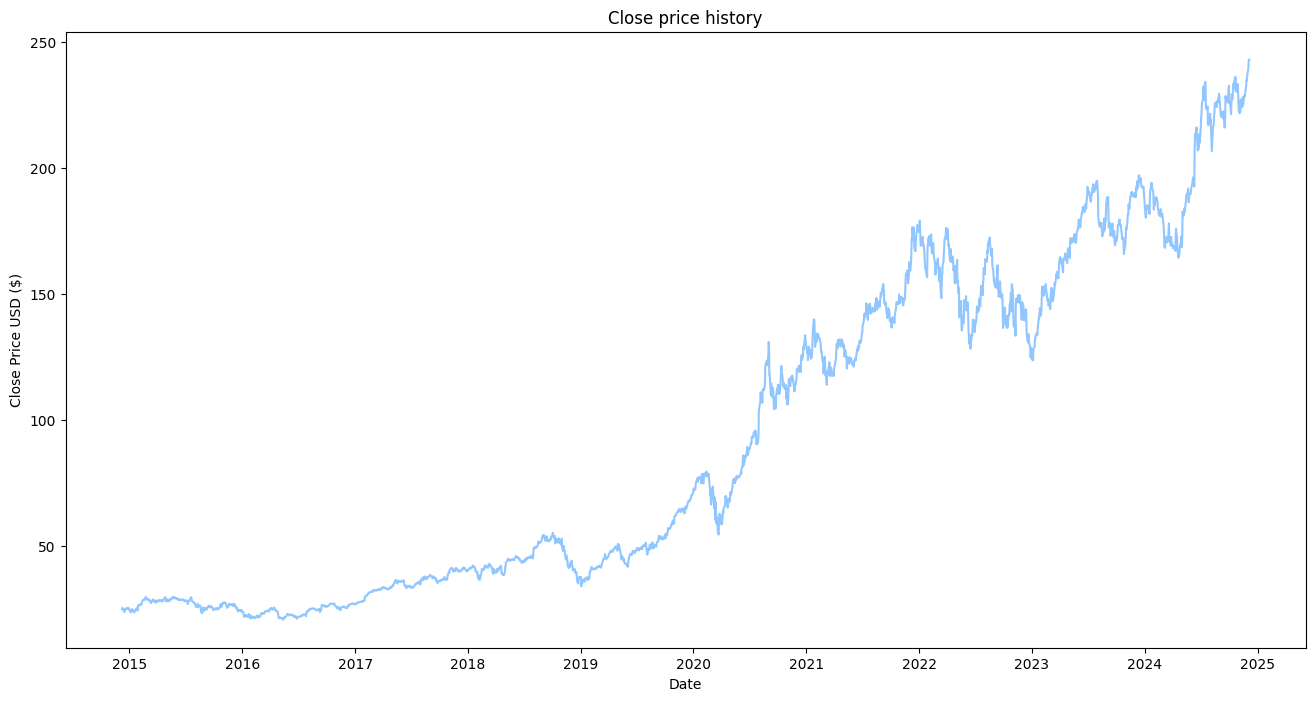

In [18]:
# Visulize the closing price
plt.figure(figsize=(16, 8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

### Data Preparation

In [20]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

2013

In [21]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01949056],
       [0.02121329],
       [0.01903984],
       ...,
       [0.99824595],
       [0.99986508],
       [1.        ]])

### Random Forest

In [23]:
# Create training dataset
train_data = scaled_data[0: training_data_len, :]
# Split the train data to x_train,  y_train
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train data
x_train_rf = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_train_rf.shape

(1953, 60)

In [24]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test, y_test
x_test, y_test = [], dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the x_test and y_test to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the x_test data
x_test_rf = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))
x_test_rf.shape

(503, 60)

In [25]:
# Build Random Forest Model
rf_model = RandomForestRegressor(n_estimators=50, max_depth=None, random_state=42)

# Train the model
rf_model.fit(x_train_rf, y_train)

# Predict on test data
predictions = rf_model.predict(x_test)
rf_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))  # Inverse transform

#### Evaluation Metrics
#### MAE:
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

#### MSE:
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

#### RMSE:
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2}
$$

In [27]:
# Random Forest Evaluations

# Evaluate predictions
mae = np.mean(np.abs(rf_predictions - y_test))
print(f"MAE: {mae:.2f}")

mse=np.mean(((rf_predictions- y_test)**2))
print(f"MSE: {mse:.2f}")

rmse=np.sqrt(np.mean(((rf_predictions- y_test)**2)))
print(f"RMSE: {rmse:.2}")

MAE: 18.46
MSE: 754.46
RMSE: 2.7e+01


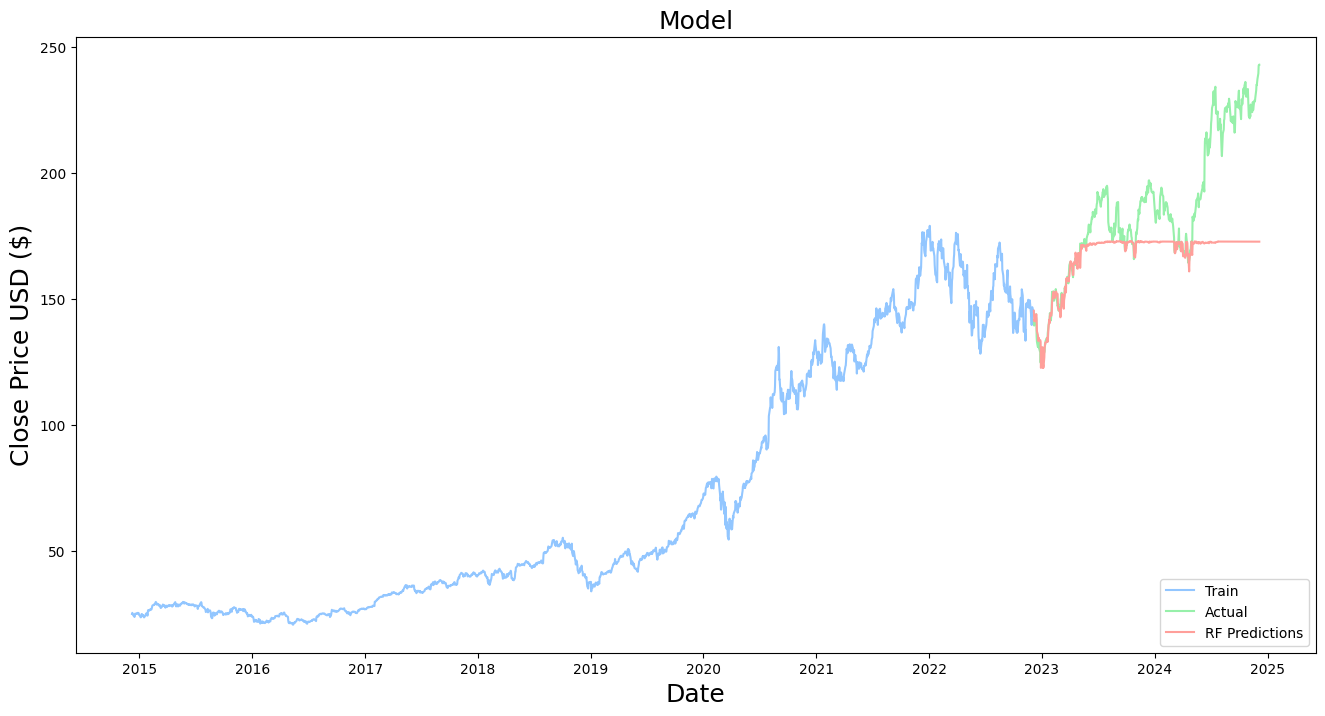

In [28]:
# Plot the data
train = data[:training_data_len]
actual = data[training_data_len:]
actual['Predictions'] = rf_predictions

# Visualize
plt.figure(figsize=(16, 8))
plt.title('Model', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'RF Predictions'], loc='lower right')
plt.show()

In [29]:
# Show valid and predicted prices of Random Forest
actual

,Close,Predictions
Date,,
2022-12-06 00:00:00-05:00,141.422806,145.357535
2022-12-07 00:00:00-05:00,139.473312,142.546267
2022-12-08 00:00:00-05:00,141.165543,141.174623
2022-12-09 00:00:00-05:00,140.680634,141.997260
2022-12-12 00:00:00-05:00,142.986359,141.421472
...,...,...
2024-11-29 00:00:00-05:00,237.330002,172.790225
2024-12-02 00:00:00-05:00,239.589996,172.790225
2024-12-03 00:00:00-05:00,242.649994,172.790225


### LSTM (Long Short-Term Memory) 

Using LSTM as it Captures sequential dependencies in time-series data.

In [31]:
# Create training dataset
train_data = scaled_data[0: training_data_len, :]
# Split the train data to x_train,  y_train
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the x_train data
x_train_lstm = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train_lstm.shape

(1953, 60, 1)

In [32]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]

# Create the data sets x_test, y_test
x_test, y_test = [], dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the x_test and y_test to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the x_test data
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test_lstm.shape

(503, 60, 1)

In [33]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_lstm.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# compile the model
model.compile(optimizer='adam', loss='mae')
# model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train_lstm, y_train, batch_size=1, epochs=1)

# Get the models predicted price values
predictions = model.predict(x_test_lstm)
lstm_predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 0s 4ms/step


In [34]:
# LSTM Evaluations

# Evaluate predictions
mae = np.mean(np.abs(lstm_predictions - y_test))
print(f"MAE: {mae:.2f}")

mse=np.mean(((lstm_predictions- y_test)**2))
print(f"MSE: {mse:.2f}")

rmse=np.sqrt(np.mean(((lstm_predictions- y_test)**2)))
print(f"RMSE: {rmse:.2}")

MAE: 16.20
MSE: 313.99
RMSE: 1.8e+01


### Visulizations

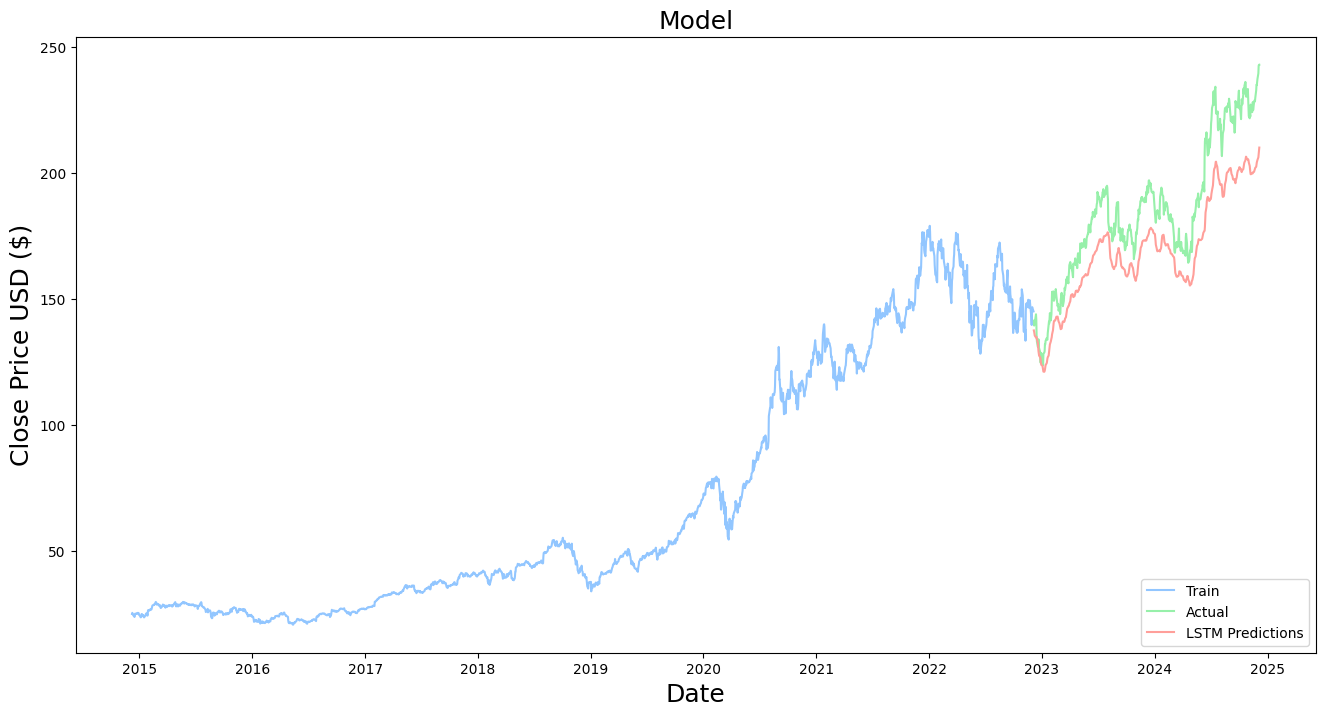

In [36]:
# Plot the data
train = data[:training_data_len]
actual = data[training_data_len:]
actual['Predictions'] = lstm_predictions

# Visualize
plt.figure(figsize=(16, 8))
plt.title('Model', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'LSTM Predictions'], loc='lower right')
plt.show()

In [37]:
# Show valid and predicted prices of LSTM
actual

,Close,Predictions
Date,,
2022-12-06 00:00:00-05:00,141.422806,137.541626
2022-12-07 00:00:00-05:00,139.473312,137.057709
2022-12-08 00:00:00-05:00,141.165543,136.184845
2022-12-09 00:00:00-05:00,140.680634,135.484604
2022-12-12 00:00:00-05:00,142.986359,134.891052
...,...,...
2024-11-29 00:00:00-05:00,237.330002,205.200226
2024-12-02 00:00:00-05:00,239.589996,206.244415
2024-12-03 00:00:00-05:00,242.649994,207.430069


### Model Comparison

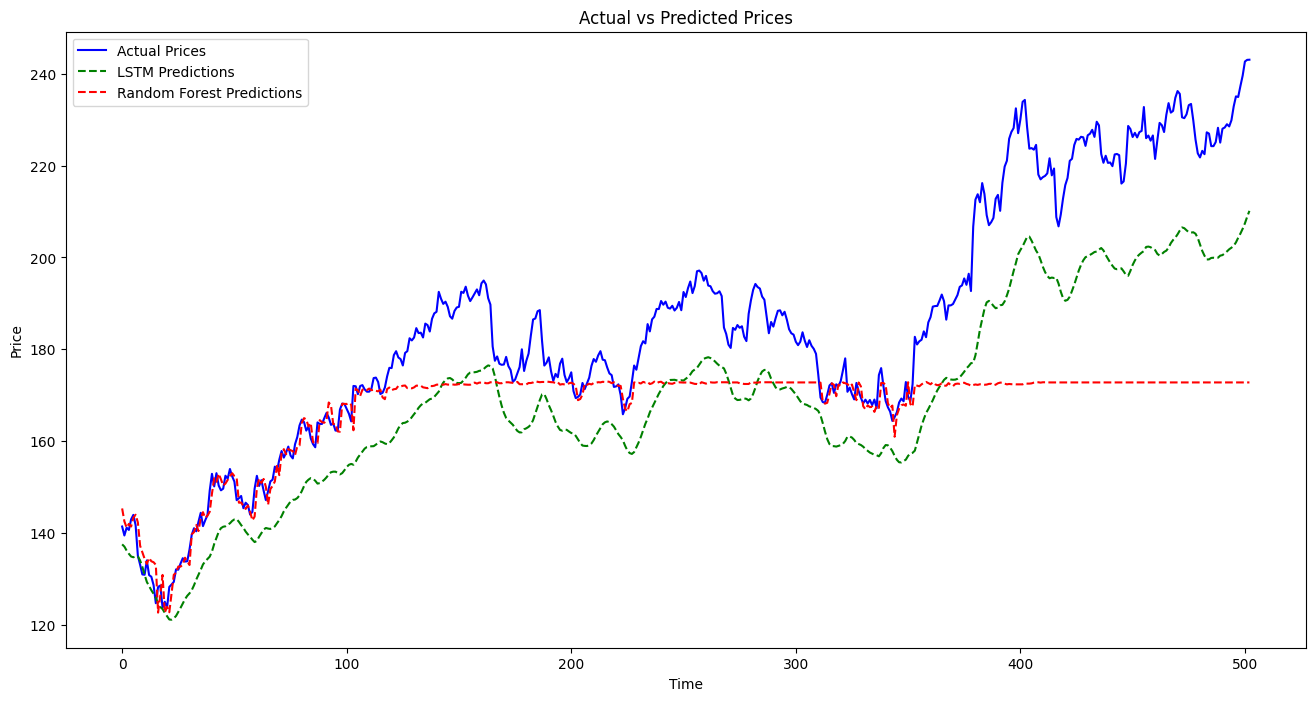

In [39]:
# Visualize comparison between LSTM and Random Forest

plt.figure(figsize=(16, 8))
plt.plot(y_test, label="Actual Prices", color="blue")
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle="--", color="green")
plt.plot(rf_predictions, label="Random Forest Predictions", linestyle="--", color="red")
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

### Model Selection

Based on the comparison above, it is evident that the LSTM model outperforms the Random Forest model in predicting values that are closer to the actual data. Therefore, we have chosen the LSTM model as the preferred approach. 

Additionally, we are using Mean Absolute Error (MAE) as the loss function, as it yielded the lowest loss value during model evaluation and is more robust to outliers due to the volatility of the stock market.

### Custom Portfolio Prediction Class

In [42]:
class StockPredictionModel:
    """
    A class to build, train, and predict stock prices using an LSTM model.
    """
    
    def __init__(self, model=Sequential, optimizer="adam", loss="mae"):
        self.model = model()
        self.optimizer = optimizer
        self.loss = loss
        
    def add_layers(self, units, shape):
        """
        Add LSTM and Dense layers to the model.
        """
        self.model.add(LSTM(units=units, return_sequences=True, input_shape=(shape, 1)))
        self.model.add(LSTM(units=units, return_sequences=False))
        self.model.add(Dense(units=max(1, units // 2)))
        self.model.add(Dense(units=1))

    def compile(self):
        """
        Compile the model with the specified optimizer and loss function.
        """
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        
    def train(self, x_train, y_train, batch_size=32, epochs=1, units=50):
        """
        Train the model with the provided training data.
        """
        self.add_layers(units, x_train.shape[1])
        self.compile()
        self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

    def predict(self, x_test, scaler):
        """
        Predict prices using the trained model.
        """
        predictions = self.model.predict(x_test)
        return scaler.inverse_transform(predictions)

    def plot_predictions(self, actual_prices, predictions):
        """
        Plot actual vs. predicted prices.
        """
        plt.figure(figsize=(16, 8))
        plt.plot(actual, label="Actual Prices")
        plt.plot(predicted, label="Predicted Prices", linestyle="--")
        plt.legend()
        plt.title("Actual vs. Predicted Prices")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.show()


In [43]:
class Stock:
    """
    A class for fetching stock data and training a prediction model.
    """
    def __init__(self, stock, start = None, end = None, time_range = 60):
        """
        Initialize the Stock object with stock data and parameters.
        """
        self.stock = stock
        self.start = start or dt.today() - timedelta(days=365*10)
        self.end = end or dt.today()
        self.time_range = time_range

        try:
            self.dataset = yf.Ticker(stock).history(start=start, end=end)
        except Exception as e:
            raise ValueError(f"Error fetching data for {stock}: {e}")

        if self.dataset.empty:
            raise ValueError(f"No data found for {stock} in the given time range.")

        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def prepare_data(self):
        """
        Prepare training and testing datasets.
        """
        data = self.dataset['Close'].values
        training_data_len = math.ceil(len(data) * 0.8)

        # Scale data
        scaled_data = self.scaler.fit_transform(data.reshape(-1, 1))

        # Create training data
        x_train, y_train = [], []
        for i in range(self.time_range, training_data_len):
            x_train.append(scaled_data[i - self.time_range:i, 0])
            y_train.append(scaled_data[i, 0])

        # Create test data
        x_test, y_test = [], data[training_data_len:]
        for i in range(training_data_len, len(scaled_data)):
            x_test.append(scaled_data[i - self.time_range:i, 0])

        # Convert to numpy arrays and reshape
        x_train, y_train = np.array(x_train), np.array(y_train)
        x_test = np.array(x_test)
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

        return x_train, y_train, x_test, y_test

    def train_model(self, epochs = 1, batch_size = 32, units = 50):
        """
        Train the prediction model.
        """
        x_train, y_train, _, _ = self.prepare_data()
        self.model = StockPredictionModel()
        self.model.train(x_train, y_train, epochs=epochs, batch_size=batch_size, units=units)
        
    
    def predict(self):
        """
        Predict future prices using the trained model.
        """
        if self.model is None:
            raise ValueError("Model has not been trained. Call `train_model` first.")

        _, _, x_test, y_test = self.prepare_data()
        predictions = self.model.predict(x_test, self.scaler)
        return predictions, y_test

In [44]:
class PortfolioPredictor:
    """
    A class to handle stock portfolio predictions using LSTM models.
    """

    def __init__(self, portfolio, start=None, end=None, time_range=60):
        self.portfolio = portfolio
        self.start = start or (dt.today() - timedelta(days=365*10))
        self.end = end or dt.today()
        self.time_range = time_range
        self.models = {}
        self.predictions = {}
        self.next_day_predictions = {}

    def train_portfolio(self, epochs=1, batch_size=32, units=50):
        """
        Train models for each stock in the portfolio.
        """
        for stock in self.portfolio:
            try:
                stock_obj = Stock(stock, start=self.start, end=self.end, time_range=self.time_range)
                stock_obj.train_model(epochs=epochs, batch_size=batch_size, units=units)
                self.models[stock] = stock_obj
                print(f"Model trained successfully for {stock}")
            except Exception as e:
                print(f"Error training model for {stock}: {e}")

    def predict_portfolio(self):
        """
        Predict prices for each stock in the portfolio.
        """
        for stock, stock_obj in self.models.items():
            try:
                predictions, actual_prices = stock_obj.predict()
                self.predictions[stock] = {"predicted": predictions, "actual": actual_prices}
            except Exception as e:
                print(f"Error predicting for {stock}: {e}")

    def predict_next_day_prices(self):
        """
        Predict the next day's price for each stock in the portfolio.
        """
        for stock, stock_obj in self.models.items():
            try:
                predictions, _ = stock_obj.predict()
                next_day_price = predictions[-1]
                self.next_day_predictions[stock] = next_day_price
            except Exception as e:
                print(f"Error predicting next-day price for {stock}: {e}")

    def calculate_profit_loss(self):
        """
        Calculate the profit/loss for the portfolio based on the predictions.
        """
        results = {}
        total_profit_loss = 0

        for stock, weight in self.portfolio.items():
            if stock in self.next_day_predictions:
                stock_obj = self.models[stock]
                current_price = stock_obj.dataset['Close'].iloc[-1]
                next_day_price = self.next_day_predictions[stock][0]
                profit_loss = (next_day_price - current_price) * weight
                results[stock] = {
                    "current_price": current_price,
                    "next_day_price": next_day_price,
                    "profit_loss": profit_loss,
                }
                total_profit_loss += profit_loss

        results["total_profit_loss"] = total_profit_loss
        return results

    def plot_portfolio_predictions(self):
        """
        Plot predictions for each stock in the portfolio.
        """
        for stock, data in self.predictions.items():
            predicted = data["predicted"]
            actual = data["actual"]
            plt.figure(figsize=(12, 6))
            plt.plot(actual, label=f"{stock} Actual Prices")
            plt.plot(predicted, label=f"{stock} Predicted Prices", linestyle="--")
            plt.title(f"{stock} - Actual vs Predicted Prices")
            plt.xlabel("Time")
            plt.ylabel("Price")
            plt.legend()
            plt.show()

    def compare_stocks(self):
        """
        Plot and compare closing prices of multiple stocks in the portfolio.
        """
        plt.figure(figsize=(12, 6))
    
        for stock in self.portfolio:
            data = yf.Ticker(stock).history(start=self.start, end=self.end)
            plt.plot(data['Close'], label=stock)
    
        plt.title("Stock Comparison")
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Close Price (USD)")
        plt.show()

62/62 [==============================] - 2s 14ms/step - loss: 0.0382
Model trained successfully for AAPL
62/62 [==============================] - 2s 14ms/step - loss: 0.0349
Model trained successfully for TSLA
62/62 [==============================] - 2s 14ms/step - loss: 0.0284
Model trained successfully for GOOGL
16/16 [==============================] - 0s 4ms/step

   Stock Current Price Next-Day Price Profit/Loss
0   AAPL       $243.04        $226.99      $-8.02
1   TSLA       $369.49        $304.33     $-19.55
2  GOOGL       $172.64        $169.06      $-0.72

Total Portfolio Profit/Loss: $-28.29


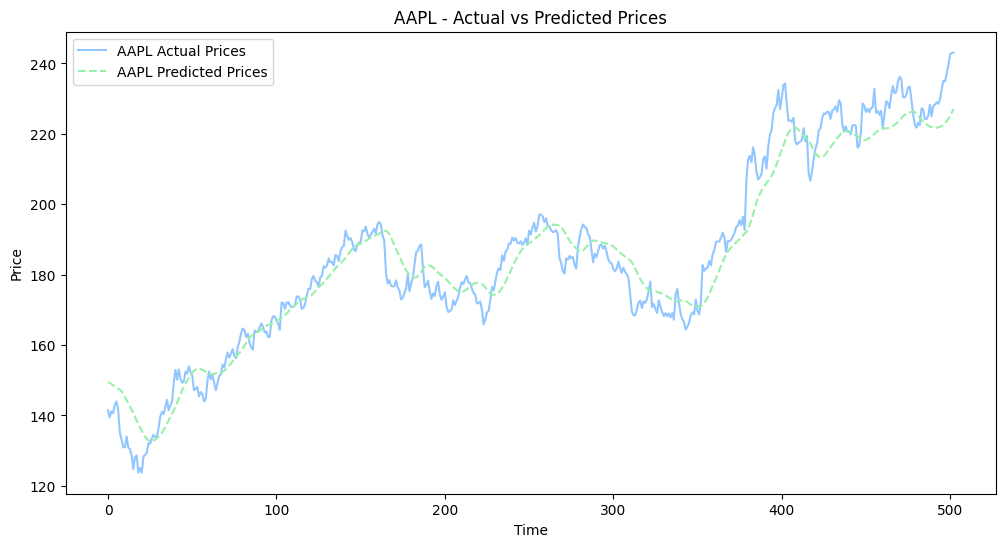

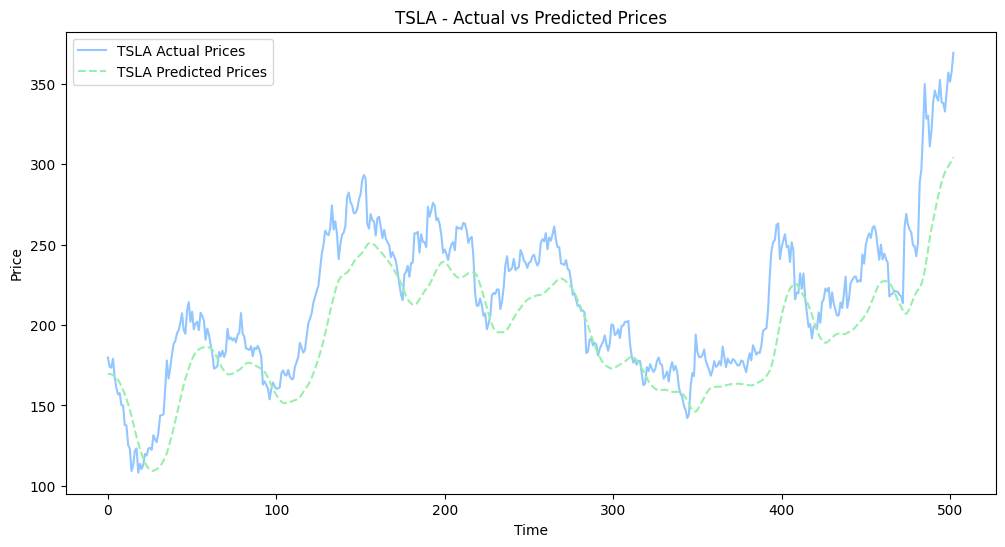

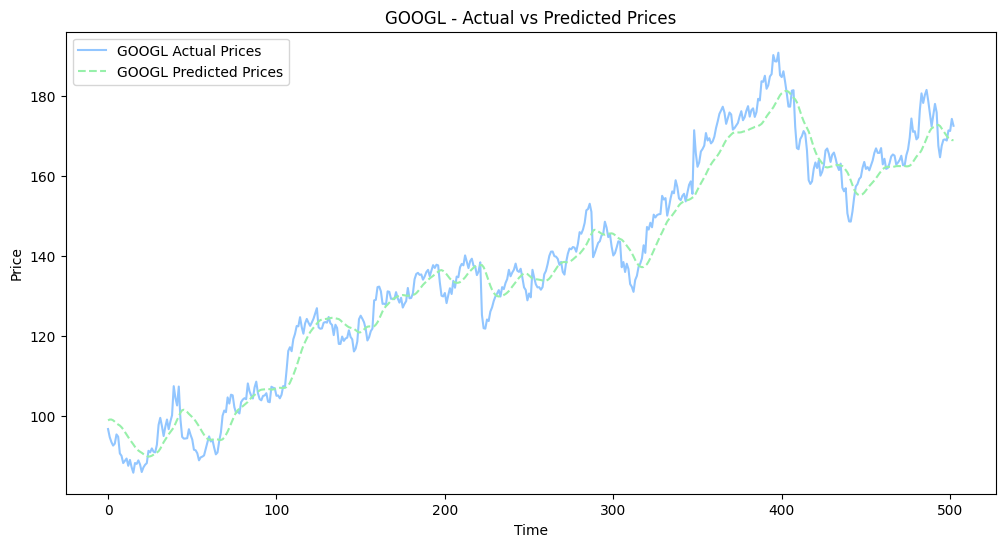

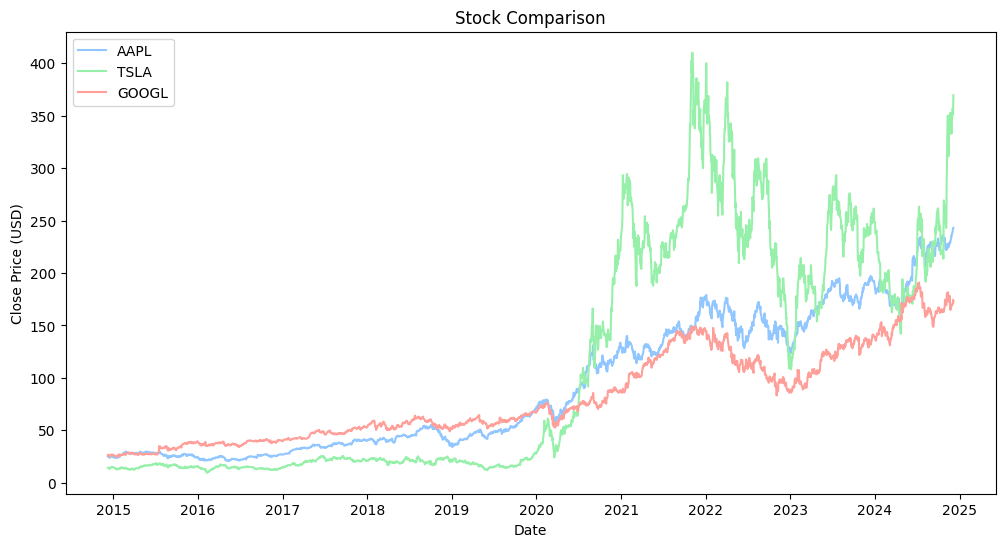

In [45]:
# Define the portfolio
portfolio = {
    "AAPL": 0.5,  
    "TSLA": 0.3, 
    "GOOGL": 0.2 
}

predictor = PortfolioPredictor(portfolio)

# Train models for the portfolio
predictor.train_portfolio(epochs=1, batch_size=32, units=50)

# Predict for the portfolio
predictor.predict_portfolio()

# Predict next-day prices
predictor.predict_next_day_prices()

# Calculate profit/loss
profit_loss_results = predictor.calculate_profit_loss()
pd.DataFrame

# Display results
print()
# Convert data to a pandas DataFrame
data = [
    {"Stock": stock, "Current Price": f"${data['current_price']:.2f}", 
     "Next-Day Price": f"${data['next_day_price']:.2f}", 
     "Profit/Loss": f"${data['profit_loss']:.2f}"}
    for stock, data in profit_loss_results.items() if stock != "total_profit_loss"
]

df = pd.DataFrame(data)

# Display table
print(df)

# Add total profit/loss row
print("\nTotal Portfolio Profit/Loss:", f"${profit_loss_results['total_profit_loss']:.2f}")

# Plot the predictions
predictor.plot_portfolio_predictions()

# Plot the comparisons
predictor.compare_stocks()

Volatility of the Stocks: TSLA and GOOGL may have higher volatility than AAPL. More volatile stocks often have irregular price movements, making predictions harder.

### References

- [LSTM](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/)
- [Sequential Model](https://keras.io/guides/sequential_model/)
- [Yahoo Finance](https://medium.com/@euricopaes/extracting-data-from-yahoo-finance-with-yfinance-96798253d8ca)
- [Stock Price Prediction using Python](https://youtu.be/QIUxPv5PJOY?si=PKt44abYBiXmbjg1)